In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
train = pd.read_parquet('./train.parquet')
test = pd.read_parquet('./test.parquet')
train = train.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)
test = test.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)

In [2]:
train.columns

Index(['id', 'base_date', 'day_of_week', 'base_hour', 'lane_count',
       'road_rating', 'road_name', 'multi_linked', 'connect_code',
       'maximum_speed_limit', 'weight_restricted', 'road_type',
       'start_node_name', 'start_latitude', 'start_longitude',
       'start_turn_restricted', 'end_node_name', 'end_latitude',
       'end_longitude', 'end_turn_restricted', 'target'],
      dtype='object')

In [70]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4686836 entries, 0 to 4701216
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int64  
 2   day_of_week            int64  
 3   base_hour              int64  
 4   lane_count             int64  
 5   road_rating            int64  
 6   road_name              int64  
 7   multi_linked           int64  
 8   connect_code           int64  
 9   maximum_speed_limit    int64  
 10  weight_restricted      int64  
 11  road_type              int64  
 12  start_node_name        int64  
 13  start_latitude         int64  
 14  start_longitude        int64  
 15  start_turn_restricted  int64  
 16  end_node_name          int64  
 17  end_latitude           float64
 18  end_longitude          float64
 19  end_turn_restricted    int64  
 20  target                 float64
 21  distance               float64
dtypes: float64(4), int

In [43]:
pd.read_csv('./data_info.csv')

,변수명,변수 설명
0,id,아이디
1,base_date,날짜
2,day_of_week,요일
3,base_hour,시간대
4,road_in_use,도로사용여부
5,lane_count,차로수
6,road_rating,도로등급
7,multi_linked,중용구간 여부
8,connect_code,연결로 코드
9,maximum_speed_limit,최고속도제한


(array([ 79062.,      0.,      0.,      0.,      0., 126893.,      0.,
             0.,      0.,  85286.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

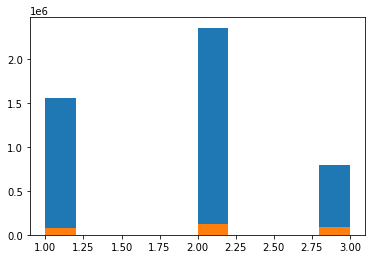

In [7]:
import matplotlib.pyplot as plt
plt.hist(train['lane_count'])
plt.hist(test['lane_count'])

<AxesSubplot:>

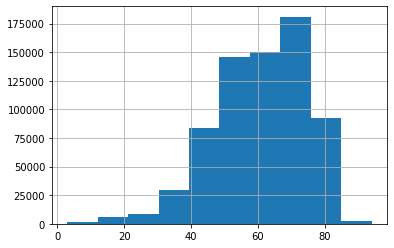

In [23]:
tp = train[train['maximum_speed_limit'] == 80]
tp['target'].hist()

<AxesSubplot:>

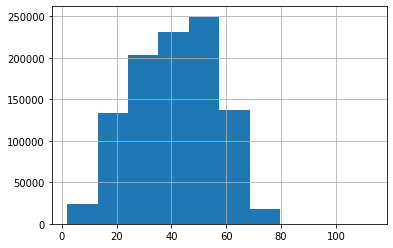

In [24]:
tp = train[train['maximum_speed_limit'] == 70]
tp['target'].hist()

<AxesSubplot:>

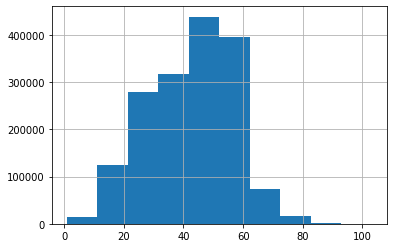

In [25]:
tp = train[train['maximum_speed_limit'] == 60]
tp['target'].hist()

<AxesSubplot:>

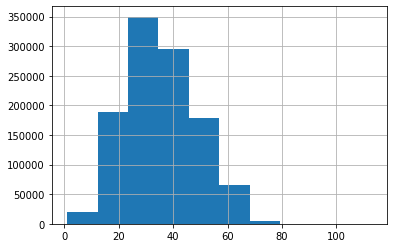

In [32]:
tp = train[train['maximum_speed_limit'] == 50]
tp['target'].hist()

<AxesSubplot:>

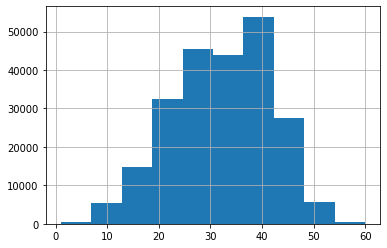

In [27]:
tp = train[train['maximum_speed_limit'] == 30]
tp['target'].hist()

In [36]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

def rf_speed(speed):
    train = pd.read_parquet('./train.parquet')
    test = pd.read_parquet('./test.parquet')
    train = train.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)
    test = test.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)

    
    str_col = ["base_hour","day_of_week","lane_count","road_rating","multi_linked","connect_code"
           ,"weight_restricted","road_type","start_latitude","start_longitude","start_turn_restricted",
          "end_turn_restricted","road_name","start_node_name","end_node_name",'end_latitude','end_longitude'] # "maximum_speed_limit"
    for i in str_col:
        le = LabelEncoder()
        le=le.fit(train[i])
        train[i]=le.transform(train[i])

        for label in np.unique(test[i]):
            if label not in le.classes_: 
                le.classes_ = np.append(le.classes_, label)
        test[i]=le.transform(test[i])
        
    train = train[train["maximum_speed_limit"]==speed]
    y_train = train['target'] 
    X_train = train.drop(['id', 'target',"base_date"], axis=1)

    test = test[test["maximum_speed_limit"]==speed]
    test_id = test['id']
    test = test.drop(['id',"base_date"], axis=1)
    
    prediction_table = pd.DataFrame(test_id)
    
    X_train,X_test,y_train,y_test = train_test_split(
        X_train,y_train,test_size=0.05,random_state=10
    )
    
    r1 = RandomForestRegressor(random_state=10)
#     r2 = CatBoostRegressor(random_state=10)
#     r3 = ExtraTreesRegressor(random_state=10)
#     vote = VotingRegressor([('r1', r1), ('r2', r2), ('r3', r3)])
    
#     parms = {'verbose':[True]}
#     grid_cv = GridSearchCV(vote,param_grid=parms,cv=5,n_jobs=-1,scoring='neg_mean_absolute_error')# ,param_grid=parms
    r1.fit(X_train,y_train)
    
    pred = r1.predict(X_test)
    mae = mean_absolute_error(pred,y_test)
    print(mae)
    
    prediction_table['target'] = r1.predict(test)
    prediction_table.to_csv(f'./target{speed}.csv')
    print(f'save {speed}')

In [37]:
rf_speed(80)
rf_speed(70)
rf_speed(60)
rf_speed(50)
rf_speed(30) # voting 

3.183664392208864
save 80
3.7756478067256523
save 70
3.5392702067268336
save 60
3.7536409194748983
save 50
2.878623274703425
save 30


In [33]:
ans = pd.concat([pd.read_csv('target30.csv'),pd.read_csv('target50.csv'),
          pd.read_csv('target60.csv'),pd.read_csv('target70.csv'),
          pd.read_csv('target80.csv')]).drop('Unnamed: 0',axis=1)
ans = ans.sort_values('id')
ans = ans.set_index('id')
ans.to_csv('./submit.csv')

In [ ]:
train['base_date'].value_counts

In [96]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
train = pd.read_parquet('./train.parquet')
test = pd.read_parquet('./test.parquet')
train = train.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)
test = test.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)

In [97]:
from haversine import haversine, Unit, haversine_vector
start = [(i-90,j) for i,j in zip(train['start_longitude'],train['start_latitude'])]
end = [(i-90,j) for i,j in zip(train['end_longitude'],train['end_latitude'])]
distance = [haversine(i, j, unit=Unit.KILOMETERS) for i,j in zip(start,end)]

# train = train.drop(['start_longitude','end_longitude','start_latitude','end_latitude'],axis=1)
train['distance'] = distance

In [98]:
from haversine import haversine, Unit, haversine_vector
start = [(i-90,j) for i,j in zip(test['start_longitude'],test['start_latitude'])]
end = [(i-90,j) for i,j in zip(test['end_longitude'],test['end_latitude'])]
distance = [haversine(i, j, unit=Unit.KILOMETERS) for i,j in zip(start,end)]

# train = train.drop(['start_longitude','end_longitude','start_latitude','end_latitude'],axis=1)
test['distance'] = distance

In [71]:
train

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,distance
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0,0.030806
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0,0.484324
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0,0.722014
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0,0.117894
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0,0.402515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,TRAIN_4701212,20211104,목,16,1,107,-,0,0,50.0,...,대림사거리,33.422145,126.278125,없음,금덕해운,33.420955,126.273750,없음,20.0,0.497979
4701213,TRAIN_4701213,20220331,목,2,2,107,-,0,0,80.0,...,광삼교,33.472505,126.424368,없음,광삼교,33.472525,126.424890,없음,65.0,0.058066
4701214,TRAIN_4701214,20220613,월,22,2,103,일반국도12호선,0,0,60.0,...,고성교차로,33.447183,126.912579,없음,성산교차로,33.444121,126.912948,없음,30.0,0.275295
4701215,TRAIN_4701215,20211020,수,2,2,103,일반국도95호선,0,0,80.0,...,제6광령교,33.443596,126.431817,없음,관광대학입구,33.444996,126.433332,없음,73.0,0.209894


In [66]:
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

def rf_speed(speed,train,test):
    # train = pd.read_parquet('./train.parquet')
    # test = pd.read_parquet('./test.parquet')
    # train = train.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)
    # test = test.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)

    
    str_col = ["base_hour","day_of_week","lane_count","road_rating","multi_linked","connect_code"
           ,"weight_restricted","road_type","start_turn_restricted","start_latitude","start_longitude",
          "end_turn_restricted","road_name","start_node_name","end_node_name"] # "maximum_speed_limit"
    for i in str_col:
        le = LabelEncoder()
        le=le.fit(train[i])
        train[i]=le.transform(train[i])

        for label in np.unique(test[i]):
            if label not in le.classes_: 
                le.classes_ = np.append(le.classes_, label)
        test[i]=le.transform(test[i])
        
    train = train[train["maximum_speed_limit"]==speed]
    y_train = train['target'] 
    X_train = train.drop(['id', 'target','base_date','end_latitude','end_longitude'], axis=1)

    test = test[test["maximum_speed_limit"]==speed]
    test_id = test['id']
    test = test.drop(['id','base_date','end_latitude','end_longitude'], axis=1)
    
    prediction_table = pd.DataFrame(test_id)
    
    X_train,X_test,y_train,y_test = train_test_split(
        X_train,y_train,test_size=0.2,random_state=10
    )
    
    r1 = RandomForestRegressor(random_state=10)
#     r2 = CatBoostRegressor(random_state=10)
#     r3 = ExtraTreesRegressor(random_state=10)
#     vote = VotingRegressor([('r1', r1), ('r2', r2), ('r3', r3)])
    
#     parms = {'verbose':[True]}
#     grid_cv = GridSearchCV(vote,param_grid=parms,cv=5,n_jobs=-1,scoring='neg_mean_absolute_error')# ,param_grid=parms
    r1.fit(X_train,y_train)
    
    pred = r1.predict(X_test)
    mae = mean_absolute_error(pred,y_test)
    print(mae)
    
    prediction_table['target'] = r1.predict(test)
    prediction_table.to_csv(f'./target{speed}.csv')
    print(f'save {speed}')

In [ ]:
rf_speed(80,train,test)
rf_speed(70,train,test)
rf_speed(60,train,test)
rf_speed(50,train,test)
rf_speed(30,train,test) # voting 

3.183663798254019
save 80
3.7756478067256523
save 70


In [59]:
ans = pd.concat([pd.read_csv('target30.csv'),pd.read_csv('target50.csv'),
          pd.read_csv('target60.csv'),pd.read_csv('target70.csv'),
          pd.read_csv('target80.csv')]).drop('Unnamed: 0',axis=1)
ans = ans.sort_values('id')
ans = ans.set_index('id')
ans.to_csv('./submit.csv')

In [14]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
train = pd.read_parquet('./train.parquet')
test = pd.read_parquet('./test.parquet')
train = train.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)
test = test.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)

from haversine import haversine, Unit, haversine_vector
start = [(i-90,j) for i,j in zip(train['start_longitude'],train['start_latitude'])]
end = [(i-90,j) for i,j in zip(train['end_longitude'],train['end_latitude'])]
distance = [haversine(i, j, unit=Unit.KILOMETERS) for i,j in zip(start,end)]

# train = train.drop(['start_longitude','end_longitude','start_latitude','end_latitude'],axis=1)
train['distance'] = distance

from haversine import haversine, Unit, haversine_vector
start = [(i-90,j) for i,j in zip(test['start_longitude'],test['start_latitude'])]
end = [(i-90,j) for i,j in zip(test['end_longitude'],test['end_latitude'])]
distance = [haversine(i, j, unit=Unit.KILOMETERS) for i,j in zip(start,end)]

# train = train.drop(['start_longitude','end_longitude','start_latitude','end_latitude'],axis=1)
test['distance'] = distance

In [15]:
train = train[train['connect_code'] == 0]
train = train[train['multi_linked'] == 0]
train = train[train['maximum_speed_limit'] != 40]

In [56]:
train['distance'].value_counts()

0.215878    12874
0.035943    12147
1.397242    12147
0.035933    12145
1.229326    12145
            ...  
0.167521     1815
0.344960     1331
0.066015      744
0.225175      744
0.148195      587
Name: distance, Length: 453, dtype: int64

In [57]:
tar = list(pd.DataFrame(test['distance'].value_counts()).index)
tar

[0.67268833385654,
 0.33915878709980957,
 0.20668484338966414,
 0.08955955279377349,
 0.03593275413632287,
 0.37229371424114666,
 0.05273737413525318,
 0.07279785941930236,
 0.11592391047789022,
 0.5082702110606651,
 0.25224811430230243,
 0.7429078524928303,
 0.24954921130045646,
 0.37848322218935077,
 0.05693597492604244,
 0.3202978304119946,
 0.06434689548810284,
 0.0359430909593352,
 0.086901590009753,
 1.397242461550045,
 0.182334641871123,
 0.0897065671471337,
 0.8622000009385835,
 0.19084322928092257,
 0.1668385620052133,
 1.2418597796600326,
 0.3068062715476612,
 0.09971489090434124,
 0.4930876396835597,
 0.31264890661195693,
 1.035180146237611,
 1.969909366041862,
 1.2293260363739213,
 1.2417480668005945,
 0.032676649959565825,
 0.6730273073786787,
 0.24791513851018523,
 0.8895691351525477,
 0.23099853040934334,
 0.09522158513844642,
 0.24977230097340294,
 0.524277097536509,
 0.12895977026124433,
 0.22677863827809377,
 0.3459478127006684,
 0.19634018896592687,
 0.42094453599257

In [54]:
ans = 0
train_set = set(train['distance'].value_counts().keys())
for i in tar:
    if i in train_set:
        ans += 1
ans

226

In [68]:
tp = train[train['road_name'] == 38]
tp.loc[0,'distance']

KeyError: 0

In [67]:
train[train['road_name'] == 38].loc[0,'distance']

KeyError: 0

In [61]:
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

def rf_speed(speed,train,test):
    # train = pd.read_parquet('./train.parquet')
    # test = pd.read_parquet('./test.parquet')
    # train = train.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)
    # test = test.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)
    
    str_col = ["base_hour","day_of_week","lane_count","road_rating","multi_linked","connect_code"
           ,"weight_restricted","road_type","start_turn_restricted","start_latitude","start_longitude",
          "end_turn_restricted","road_name","start_node_name","end_node_name","maximum_speed_limit"]
    for i in str_col:
        le = LabelEncoder()
        le=le.fit(train[i])
        train[i]=le.transform(train[i])

        for label in np.unique(test[i]):
            if label not in le.classes_: 
                le.classes_ = np.append(le.classes_, label)
        test[i]=le.transform(test[i])
        
    train = train[train["distance"]==speed]
    y_train = train['target'] 
    X_train = train.drop(['id','target','connect_code','multi_linked','base_date'], axis=1)

    test = test[test["distance"]==speed]
    test_id = test['id']
    test = test.drop(['id','connect_code','multi_linked','base_date'], axis=1)
    
    prediction_table = pd.DataFrame(test_id)
    
    X_train,X_test,y_train,y_test = train_test_split(
        X_train,y_train,test_size=0.04,random_state=10
    )
    
    r1 = RandomForestRegressor(random_state=10)
#     r2 = CatBoostRegressor(random_state=10)
#     r3 = ExtraTreesRegressor(random_state=10)
#     vote = VotingRegressor([('r1', r1), ('r2', r2), ('r3', r3)])
    
#     parms = {'verbose':[True]}
#     grid_cv = GridSearchCV(vote,param_grid=parms,cv=5,n_jobs=-1,scoring='neg_mean_absolute_error')# ,param_grid=parms
    r1.fit(X_train,y_train)
    
    pred = r1.predict(X_test)
    mae = mean_absolute_error(pred,y_test)
    print(mae)
    
    prediction_table['target'] = r1.predict(test)
    prediction_table.to_csv(f'./distance/target{speed}.csv')
    print(f'save {speed}')

In [62]:
for idx in tar:
    rf_speed(idx,train,test)

3.5048856042684577
save 0.67268833385654
3.5864579877505234
save 0.33915878709980957
2.944645072898933
save 0.20668484338966414
3.115276179802213
save 0.08955955279377349
3.363036885376842
save 0.03593275413632287
3.601377497371002
save 0.37229371424114666
2.2071981553630553
save 0.05273737413525318
5.069137435420349
save 0.07279785941930236
2.2623560034019445
save 0.11592391047789022
4.362823742661117
save 0.5082702110606651
4.148000709884974
save 0.25224811430230243
2.54536069048129
save 0.7429078524928303
3.1962270559217796
save 0.24954921130045646
3.2647068339622867
save 0.37848322218935077
3.0708770160952086
save 0.05693597492604244
2.7014722921082814
save 0.3202978304119946
2.7112839268777718
save 0.06434689548810284
4.3146089439879445
save 0.0359430909593352
3.232298449476804
save 0.086901590009753
4.00554467112333
save 1.397242461550045
3.3152458627138004
save 0.182334641871123
2.1398276974306962
save 0.0897065671471337
2.6904408776548667
save 0.8622000009385835
4.9420830006551

4.085145861450827
save 0.0861985772932079
3.925326019449407
save 0.08777132071518902
4.159384104589761
save 0.08212072916081019
6.022152071015668
save 0.16439269789915809
8.23904457819197
save 0.08892556960729821
6.68484025544437
save 0.16784136994716647
7.254804549878138
save 0.08675233173530093
3.6709562547956622
save 0.2053246858285574
3.6367621944147803
save 0.19951634011012348
4.204939921551407
save 0.609334197377379
3.52361023317224
save 0.27413294283439704
3.601420420325762
save 0.025055822236142975
4.009100959694303
save 0.022898384616911356
4.929776588900948
save 1.9269177196187597
1.8995081330359125
save 0.048384033152054244
1.9215373351611293
save 0.04236589306511398
1.7984416806996018
save 1.0875241089322005
1.8278694896550192
save 2.1593531032513433
1.9231571220976211
save 0.02822433732303282
3.3181028088337947
save 0.5225341958032333
3.3234956217775595
save 0.9031283395215743
4.976625839185082
save 0.10755456236778049
6.130736226469474
save 0.27529497309715606
3.653047644

In [163]:
ans = pd.concat([pd.read_csv('target30.csv'),pd.read_csv('target50.csv'),
          pd.read_csv('target60.csv'),pd.read_csv('target70.csv'),
          pd.read_csv('target80.csv')]).drop('Unnamed: 0',axis=1)
ans = ans.sort_values('id')
ans = ans.set_index('id')
ans.to_csv('./submit1.csv')

In [8]:
ans = pd.read_csv('./targetabc.csv')
ans = ans.sort_values('id')
ans = ans.set_index('id')
ans = ans.drop('Unnamed: 0',axis=1)
ans.to_csv('./targetabc.csv')